<a href="https://colab.research.google.com/github/MelihKlc/Deep-Learning/blob/main/Transfer_Learning_Scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# We will get our helper function script

# Our goal is to beat the original Food101 paper's results with 10% of data.

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-08-11 16:52:52--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-08-11 16:52:52 (82.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
# Import from helper function what we need

from helper_functions import unzip_data ,  plot_loss_curves , walk_through_dir , create_tensorboard_callback , compare_historys

In [3]:
# Download 10 percent of Food Vision 101
import tensorflow as tf

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

# Set up train and test directory

train_dir = "/content/101_food_classes_10_percent/train"
test_dir = "/content/101_food_classes_10_percent/test"

# Set up training and test set datas

train_data = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir ,
                                                                 batch_size = 32 ,
                                                                 image_size = (224,224) ,
                                                                 label_mode = "categorical"
                                                                 )
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir ,
                                                                 batch_size = 32 ,
                                                                 image_size = (224,224) ,
                                                                 label_mode = "categorical" ,
                                                                 shuffle = False  # Dont shuffle test data for prediction analysis
                                                                 )

--2023-08-11 16:52:56--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 64.233.170.128, 142.251.175.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  24.9MB/s    in 70s     

2023-08-11 16:54:06 (22.1 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


# Here are the steps we are going to take:
* Create a model check point tensorboard.
* Create a data augmentation layer to build data augmentation right into the model.
* Build a headless (no top layers) functional EfficientNetB0 backboned-model ( we will create our own output layer)
* Compile our model
* Feature extract for full 5 passes ( 5 epochs on the train dataset and validation on %15 of the test data , to save epoch time)

In [4]:
# Set the checkpoint path
checkpoint_path = "101_food_classes_model_checkpoint_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path ,
    monitor = "val_accuracy" ,
    save_weights_only = True ,
    save_best_only = True
 )

In [5]:
# Data augmentation layer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = tf.keras.Sequential(
    [
        preprocessing.RandomFlip("horizontal") ,
        preprocessing.RandomZoom(0.2) ,
        preprocessing.RandomHeight(0.2) ,
        preprocessing.RandomWidth(0.2),
        preprocessing.RandomRotation(0.2)
    ] , name = "data_augmentation"

)

In [6]:
# Building feature extraction model with keras API

base_model = tf.keras.applications.EfficientNetB0(include_top = False)

base_model.trainable = False

inputs = tf.keras.layers.Input(shape = (224,224,3) , name = "input_layer")

x = data_augmentation(inputs)

x = base_model(x , training = False) # Put the base model in inference mode so weights which need to stay frozen , stay frozen

x = tf.keras.layers.GlobalAveragePooling2D()(x)

outputs = tf.keras.layers.Dense(101 , activation = "softmax" , name = "output_layer")(x)  # 101 yerine len(train_data.class_names) yazabiliriz. Class sayısını bilmedigimiz datalarda böyle yapılabilir.

model_1 = tf.keras.Model(inputs , outputs)

# Compile a model

model_1.compile(loss = ["categorical_crossentropy"] ,
                optimizer = tf.keras.optimizers.Adam() ,
                metrics = ["accuracy"]
                )

# Fit the model
initial_epochs = 5

history_1 = model_1.fit(train_data ,
                        epochs = initial_epochs ,
                        steps_per_epoch = len(train_data) ,
                        validation_data = test_data ,
                        validation_steps = int(0.15 * len(test_data)) ,
                        callbacks = [checkpoint_callback]
                        )


16705208/16705208 [==============================] - 2s 0us/step
Epoch 1/5
237/237 [==============================] - 120s 438ms/step - loss: 3.3903 - accuracy: 0.2622 - val_loss: 2.5303 - val_accuracy: 0.4356
Epoch 2/5
237/237 [==============================] - 81s 335ms/step - loss: 2.2207 - accuracy: 0.4845 - val_loss: 2.0767 - val_accuracy: 0.4992
Epoch 3/5
237/237 [==============================] - 71s 296ms/step - loss: 1.8436 - accuracy: 0.5673 - val_loss: 1.9084 - val_accuracy: 0.5201
Epoch 4/5
237/237 [==============================] - 65s 274ms/step - loss: 1.6204 - accuracy: 0.6055 - val_loss: 1.8542 - val_accuracy: 0.5215
Epoch 5/5
237/237 [==============================] - 72s 301ms/step - loss: 1.4792 - accuracy: 0.6383 - val_loss: 1.8006 - val_accuracy: 0.5347


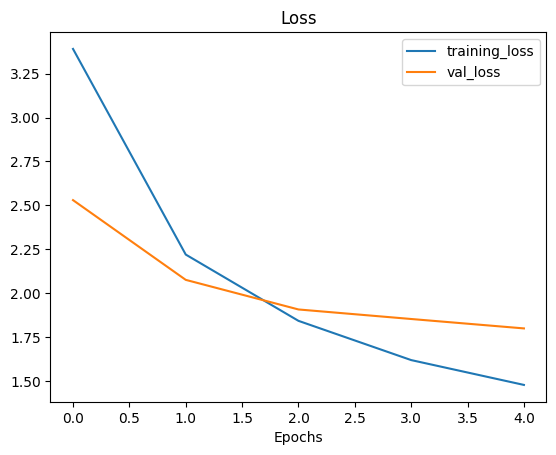

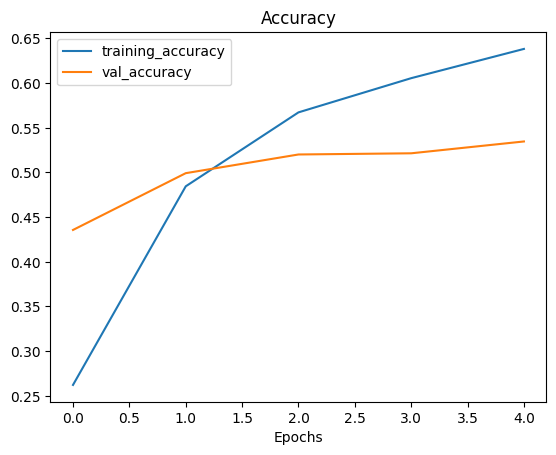

In [7]:
plot_loss_curves(history_1)

# What do these curves suggest? Hint: ideally, the two curves should be very similar to each other, if not, there may be some overfitting or underfitting.

In [8]:
model_1_evaluate = model_1.evaluate(test_data)  # 100 percent of the test data

790/790 [==============================] - 66s 83ms/step - loss: 1.5897 - accuracy: 0.5839


# Feature extraction modelimizi tamamladık ve train ettik. %57 accuracy aldık. Şimdi fine-tuning yapıcaz.

In [9]:
# Lets unfreeze all of the layers and then we will freeze all of the layers except last 10.

base_model.trainable = True

for layer in base_model.layers[ : -5]:
  layer.trainable = False

# Recompile it for fine-tuning

model_1.compile(loss = ["categorical_crossentropy"] ,
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001) ,
                metrics = ["accuracy"]
                )




In [10]:
# Fit the model
fine_tune_epochs = initial_epochs + 5  #fine tune epochs aslında bizim total number of epochs umuz oluyor. Yani eğer feature extraction yaparken 5 epoch kullandıysak burda 10 epoch belirlediğimizde fine tune için 5 epoch kullanıcaz ( 5 (feature extraction) + 5 (fine-tuning) )

history_2 = model_1.fit(train_data ,
                     epochs = fine_tune_epochs ,
                     steps_per_epoch = len(train_data) ,
                     initial_epoch = history_1.epoch[-1] ,
                     validation_data = test_data ,
                     validation_steps = int( 0.15 * len(test_data)) ,
                     callbacks = [checkpoint_callback]
                     )

Epoch 5/10
237/237 [==============================] - 71s 254ms/step - loss: 1.2443 - accuracy: 0.6803 - val_loss: 1.7633 - val_accuracy: 0.5368
Epoch 6/10
237/237 [==============================] - 56s 233ms/step - loss: 1.1161 - accuracy: 0.7040 - val_loss: 1.8051 - val_accuracy: 0.5291
Epoch 7/10
237/237 [==============================] - 51s 214ms/step - loss: 1.0463 - accuracy: 0.7197 - val_loss: 1.7684 - val_accuracy: 0.5342
Epoch 8/10
237/237 [==============================] - 48s 202ms/step - loss: 0.9779 - accuracy: 0.7391 - val_loss: 1.8145 - val_accuracy: 0.5318
Epoch 9/10
237/237 [==============================] - 49s 204ms/step - loss: 0.9367 - accuracy: 0.7451 - val_loss: 1.8318 - val_accuracy: 0.5262
Epoch 10/10
237/237 [==============================] - 47s 198ms/step - loss: 0.8695 - accuracy: 0.7613 - val_loss: 1.7739 - val_accuracy: 0.5395


In [11]:
# Evaluating fine-tuning model
fine_tune_eva = model_1.evaluate(test_data)

790/790 [==============================] - 70s 89ms/step - loss: 1.5031 - accuracy: 0.6006


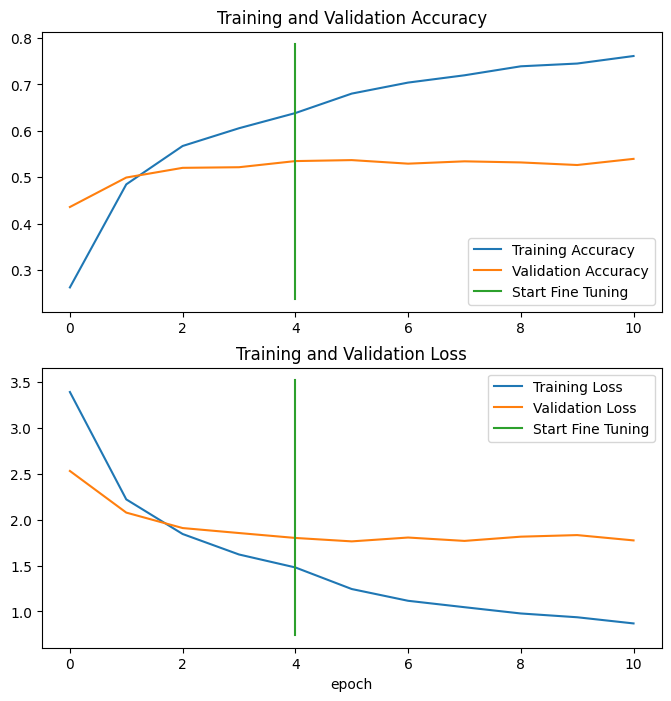

In [12]:
# Compare the results
compare_historys(original_history = history_1 ,
                 new_history = history_2 ,
                 initial_epochs = 5
                 )

# Saving and loading our model

To use our model for external application , we will need to save it and export it somewhere

In [15]:
# # Save model to drive so it can be used later
#model_1.save("drive/My Drive/101_food_class_10_percent_saved_big_dog_model")

# Evaluating the performance of our model across all different classes

Lets make some predictions , visualize them and then find out which predictions were the most wrong

In [16]:
# Download pre-trained model
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2023-08-11 17:28:50--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.251.10.128, 142.251.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  15.9MB/s    in 2.8s    

2023-08-11 17:28:53 (15.9 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [17]:
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

In [18]:
 # Load the saved model
 model_pre = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [19]:
# Evaluate loaded model
eva_model_pre = model_pre.evaluate(test_data)

790/790 [==============================] - 68s 82ms/step - loss: 1.8027 - accuracy: 0.6078


In [24]:
# Making predictions with our model

pred_probs = model_pre.predict(test_data , verbose = 1)  # Set verbosity 1 to see how long is left



790/790 [==============================] - 71s 87ms/step


In [25]:
len(test_data)

790

In [26]:
# How many predictions are there?
len(pred_probs)

25250

In [28]:
# What is the shape of our prediction. Burda outputta softmax var. Softmaxin özelliğini hatırlarsak her classa bir probability veriyor. Yani burda 1 image için 101 classın hepsine probability vercek. Meslea input olarak donut image girdik. Donut image probability 0.7 çıkacak baklava 0.0012 falan çıkacak. Mantık bu.
pred_probs.shape

(25250, 101)

In [29]:
# How first 10 predictions look like?
pred_probs[ : 10]

array([[5.9542079e-02, 3.5742114e-06, 4.1377071e-02, ..., 1.4138705e-09,
        8.3530424e-05, 3.0897493e-03],
       [9.6401680e-01, 1.3753272e-09, 8.4780494e-04, ..., 5.4286946e-05,
        7.8362065e-12, 9.8466024e-10],
       [9.5925868e-01, 3.2533771e-05, 1.4867012e-03, ..., 7.1891407e-07,
        5.4397475e-07, 4.0276118e-05],
       ...,
       [4.7313249e-01, 1.2931206e-07, 1.4805582e-03, ..., 5.9750117e-04,
        6.6969209e-05, 2.3469403e-05],
       [4.4571843e-02, 4.7265397e-07, 1.2258503e-01, ..., 6.3498451e-06,
        7.5318876e-06, 3.6778769e-03],
       [7.2438902e-01, 1.9249717e-09, 5.2310897e-05, ..., 1.2291410e-03,
        1.5792732e-09, 9.6395481e-05]], dtype=float32)

In [32]:
# First pred. As i sad , it has 101 elements because of 101 class we have. Sum of all values inside the 1 image prediction is almost 1 because we have probabilities
pred_probs[0] , len(pred_probs[0]) , sum(pred_probs[0])

(array([5.9542079e-02, 3.5742114e-06, 4.1377071e-02, 1.0660534e-09,
        8.1614422e-09, 8.6639478e-09, 8.0927344e-07, 8.5652732e-07,
        1.9859108e-05, 8.0977674e-07, 3.1727800e-09, 9.8673911e-07,
        2.8532281e-04, 7.8048890e-10, 7.4230117e-04, 3.8916227e-05,
        6.4740480e-06, 2.4977348e-06, 3.7891161e-05, 2.0678284e-07,
        1.5538406e-05, 8.1507324e-07, 2.6230616e-06, 2.0010684e-07,
        8.3827518e-07, 5.4215925e-06, 3.7390960e-06, 1.3150530e-08,
        2.7761441e-03, 2.8051916e-05, 6.8562017e-10, 2.5574853e-05,
        1.6688927e-04, 7.6406986e-10, 4.0452811e-04, 1.3150683e-08,
        1.7957391e-06, 1.4448174e-06, 2.3062844e-02, 8.2466693e-07,
        8.5365679e-07, 1.7138593e-06, 7.0525425e-06, 1.8402130e-08,
        2.8553373e-07, 7.9483443e-06, 2.0681530e-06, 1.8525149e-07,
        3.3619703e-08, 3.1522504e-04, 1.0410941e-05, 8.5448431e-07,
        8.4741855e-01, 1.0555424e-05, 4.4094787e-07, 3.7404032e-05,
        3.5306188e-05, 3.2488941e-05, 6.7314730e

In [33]:
# We get one prediction probabilites per class (in our case there is 101 prediction probabilities )

print(f"Number of predictions probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like: \n {pred_probs[0]} ")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

Number of predictions probabilities for sample 0 101
What prediction probability sample 0 looks like: 
 [5.9542079e-02 3.5742114e-06 4.1377071e-02 1.0660534e-09 8.1614422e-09
 8.6639478e-09 8.0927344e-07 8.5652732e-07 1.9859108e-05 8.0977674e-07
 3.1727800e-09 9.8673911e-07 2.8532281e-04 7.8048890e-10 7.4230117e-04
 3.8916227e-05 6.4740480e-06 2.4977348e-06 3.7891161e-05 2.0678284e-07
 1.5538406e-05 8.1507324e-07 2.6230616e-06 2.0010684e-07 8.3827518e-07
 5.4215925e-06 3.7390960e-06 1.3150530e-08 2.7761441e-03 2.8051916e-05
 6.8562017e-10 2.5574853e-05 1.6688927e-04 7.6406986e-10 4.0452811e-04
 1.3150683e-08 1.7957391e-06 1.4448174e-06 2.3062844e-02 8.2466693e-07
 8.5365679e-07 1.7138593e-06 7.0525425e-06 1.8402130e-08 2.8553373e-07
 7.9483443e-06 2.0681530e-06 1.8525149e-07 3.3619703e-08 3.1522504e-04
 1.0410941e-05 8.5448431e-07 8.4741855e-01 1.0555424e-05 4.4094787e-07
 3.7404032e-05 3.5306188e-05 3.2488941e-05 6.7314730e-05 1.2852589e-08
 2.6219654e-10 1.0318089e-05 8.5743537e-05 1

In [34]:
# Get the pred classes of each layer
pred_classes = pred_probs.argmax(axis = 1)

# How do they look?
pred_classes[ : 10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [35]:
# How many pred classes do we have ?
len(pred_classes)

25250